In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralODE_train_HOTs as ncm
import src.kdv_burgers_eqn_case.kdv_burgers_eqn as burg
from src.kdv_burgers_eqn_case.kdv_burgers_eqn_helper_classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy as spy
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__)

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Define some useful classes

### Class for user-defined arguments

In [4]:
class burg_ncm_args(ncm.ncm_arguments, burg.kdv_burg_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 tau_max = 1.1, tau = 0.2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, 
                 train_ens_size = 1, x_left = [0.], x_right = [1.], nx_train_hf = [100], nx_train_lf = [25], Re = [250], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [1], nbc_r = [0],
                 isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 4, 
                 use_analytical_sol = 0, lambda_l1_mark = 0., lambda_l2_mark = 0., 
                 lambda_l1_non_mark = 0., lambda_l2_non_mark = 0., prune_thres = 0., mse_weight = 0., max_deriv = 2,
                 acc = 2, acc_advec = 1, eta_1 = 1.2, eta_2 = 0.8, x_1 = -6.0, x_2 = -2.0, disp_term = 1): # add more arguments as needed
        
        ncm.ncm_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, 
                           tau_max = tau_max, tau = tau, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)
        
        Re = [np.nan for i in range(len(nx_train_lf))]
        nx_train_hf = [200 for i in range(len(nx_train_lf))]
        
        self.args_train_hf = []
        for i in range(train_ens_size):
            self.args_train_hf.append(burg.kdv_burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv, 
                                         acc = acc, acc_advec = acc_advec, eta_1 = eta_1, eta_2 = eta_2, x_1 = x_1, x_2 = x_2, disp_term = disp_term))
            
        self.args_train_lf = []
        for i in range(train_ens_size):
            self.args_train_lf.append(burg.kdv_burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec, eta_1 = eta_1, eta_2 = eta_2, x_1 = x_1, x_2 = x_2, disp_term = disp_term))
        
        self.train_ens_size = train_ens_size
        i = ens_to_plot
        self.args_eval_hf = burg.kdv_burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_hf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec, eta_1 = eta_1, eta_2 = eta_2, x_1 = x_1, x_2 = x_2, disp_term = disp_term)
        self.args_eval_lf = burg.kdv_burg_args(T = T, nt = nt, x_left = x_left[i], x_right = x_right[i], Nx = nx_train_lf[i], Re = Re[i], 
                                         dleft_bv_dt = dleft_bv_dt[i], dright_bv_dt = dright_bv_dt[i], dbc_l = dbc_l[i], 
                                         nbc_l = nbc_l[i], dbc_r = dbc_r[i], nbc_r = nbc_r[i], max_deriv = max_deriv,
                                         acc = acc, acc_advec = acc_advec, eta_1 = eta_1, eta_2 = eta_2, x_1 = x_1, x_2 = x_2, disp_term = disp_term)
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps
        self.read_hf_data = read_hf_data
        self.read_hf_data_fac = read_hf_data_fac
        self.use_analytical_sol = use_analytical_sol
        
        self.lambda_l1_mark = lambda_l1_mark
        self.lambda_l2_mark = lambda_l2_mark
        self.lambda_l1_non_mark = lambda_l1_non_mark
        self.lambda_l2_non_mark = lambda_l2_non_mark
        self.prune_thres = prune_thres
        self.mse_weight = mse_weight

In [5]:
### Define a custom plotting function
class custom_plot:

    def __init__(self, true_y, y_no_nn, x, t, figsave_dir, args, restart = 0):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.figsave_dir = figsave_dir
        self.args = args
        self.X, self.T = np.meshgrid(x.numpy(), t.numpy())
        self.x = x
        self.restart = restart
            
    def plot(self, *pred_y, epoch = 0):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_u_lowres = fig.add_subplot(221)
        ax_u_diff = fig.add_subplot(222)
        ax_u_nn = fig.add_subplot(223)
        ax_u_diff_nn = fig.add_subplot(224)
        
        ax_u_lowres.cla()
        ax_u_lowres.set_title('Low-Res Solution', fontsize=14)
        ax_u_lowres.set_xlabel('x', fontsize=14)
        ax_u_lowres.set_ylabel('t', fontsize=14)
        plot = ax_u_lowres.contourf(self.X, self.T, tf.squeeze(self.y_no_nn, axis=1).numpy(), cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, 3.0, 20), extend='min')
        ax_u_lowres.set_xlim(self.x[0], self.x[-1])
        ax_u_lowres.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_lowres, shrink=0.5, aspect=10)

        ax_u_diff.cla()
        ax_u_diff.set_title('|Difference without NN|', fontsize=14)
        ax_u_diff.set_xlabel('x', fontsize=14)
        ax_u_diff.set_ylabel('t', fontsize=14)
        plot = ax_u_diff.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - self.y_no_nn, axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                            antialiased=False, levels=np.linspace(0, 2., 20))
        ax_u_diff.set_xlim(self.x[0], self.x[-1])
        ax_u_diff.set_ylim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax_u_diff, shrink=0.5, aspect=10)
        
        if epoch >= 0 or self.restart == 1 :
            ax_u_nn.cla()
            ax_u_nn.set_title('Low-Res with nCM Solution', fontsize=14)
            ax_u_nn.set_xlabel('x', fontsize=14)
            ax_u_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_nn.contourf(self.X, self.T, tf.squeeze(pred_y[0][:, :, 0:self.args.state_dim], axis=1).numpy(), cmap=cm.coolwarm,
                               antialiased=False, levels=np.linspace(0, 3.0, 20), extend='min')
            ax_u_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_nn, shrink=0.5, aspect=10)

            ax_u_diff_nn.cla()
            ax_u_diff_nn.set_title('|Difference|', fontsize=14)
            ax_u_diff_nn.set_xlabel('x', fontsize=14)
            ax_u_diff_nn.set_ylabel('t', fontsize=14)
            plot = ax_u_diff_nn.contourf(self.X, self.T, tf.abs(tf.squeeze(self.true_y - pred_y[0][:, :, 0:self.args.state_dim], axis=1)).numpy(), cmap=plt.get_cmap('coolwarm'),
                                antialiased=False, levels=np.linspace(0, 2., 20))
            ax_u_diff_nn.set_xlim(self.x[0], self.x[-1])
            ax_u_diff_nn.set_ylim(self.t[0], self.t[-1])
            plt.colorbar(plot, ax=ax_u_diff_nn, shrink=0.5, aspect=10)

        plt.show()
        
        if epoch != 0: 
            fig.savefig(os.path.join(self.figsave_dir, 'img'+str(epoch)))

### Define the neural net architecture

In [6]:
class NNFunc_mark(tf.keras.Model):

    def __init__(self, **kwargs):
        super(NNFunc_mark, self).__init__(**kwargs)
        
        self.out = tf.keras.layers.Dense(1, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.001), use_bias=False)
        
    
    def norm_init(self, norm_const, dx):
        self.norm_const = norm_const
        self.dx_lin = tf.stack([dx**0, dx**0, dx**0, dx**0], axis=-1)
        self.dx_mult = tf.stack([dx**0, dx**2, dx**4, dx**2], axis=-1)
        self.dx_mult2 = tf.stack([dx**1, dx**3], axis=-1)
        
    def process_input(self, y, shp):     
               
        y = tf.reshape(y, shp)
        
        return y
    
    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z_shp = tf.shape(z)
        
        z = self.process_input(z, [-1, z_shp[-1]])
        
        z = tf.cast(z, tf.float64)
        
        z_advec = tf.einsum('ab, ab -> ab', z[:, 0:1], z[:, 1:2])
        
        z_z_advec = tf.einsum('ab, ab -> ab', z[:, 0:1], z_advec)
        
        z = tf.cast(tf.concat([z[:, 2:], z_advec, z_z_advec], axis=-1), tf.float32)
        
        z = self.pass_layers(tf.cast(z, tf.float32))
        
        z = self.process_input(z, z_shp[0:-1])
        
        return z

In [7]:
class ODEFunc(tf.keras.Model):

    def __init__(self, mark_nn_part, rom_model, app, norm_const, **kwargs):
        super(ODEFunc, self).__init__(**kwargs)
        self.mark_nn_part = mark_nn_part
        
        dx = rom_model.grid.x_grid[1] - rom_model.grid.x_grid[0] 
        dx = tf.convert_to_tensor([dx])
        self.mark_nn_part.norm_init(norm_const, dx)
        
        self.rom_model = rom_model
        self.args = app
        
    def overwrite_rom(self, app, rom_model, norm_const):
        self.rom_model = rom_model
        dx = rom_model.grid.x_grid[1] - rom_model.grid.x_grid[0]
        dx = tf.convert_to_tensor([dx])
        self.args = app
        self.mark_nn_part.norm_init(norm_const, dx)
        
    def process_input(self, zy, t ,tau, flag_fwd=0):     
        
        input = [self.compute_derivatives(zy(t)[:, :self.args.state_dim], flag_fwd)]
        
        return input
    
    def call_nn_part_indiv(self, z, flag_mark = 0, flag_fwd = 0):
        
        z = self.compute_derivatives(z, flag_fwd)
        
        return self.mark_nn_part(z)
    
    def compute_derivatives(self, u, flag_fwd = 0):
        if flag_fwd:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx_upwind, u.numpy())
        else:
            u_x = np.einsum('ab, cb -> ca', self.rom_model.full_vander_dx, u.numpy())
        
        u_stack = [u, u_x]
        
        for i in range(2, self.args.max_deriv+1):
            u_stack.append(np.einsum('ab, cb -> ca', self.rom_model.full_vander[i], u.numpy()))
        
        u_stack = tf.convert_to_tensor(np.stack(u_stack, axis=-1))
        
        return u_stack

    def __call__(self, uy, t ,tau, t_start = np.array([0.])):    
        
        input = self.process_input(uy, t ,tau, flag_fwd=1)
        
        u_t = input[0][:, :, 0]
        u_t_int = u_t[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)]
        
        du_dt_int = self.rom_model.rhs_int(t, u_t.numpy(), u_t_int.numpy())
        
        du_dt_int = du_dt_int + self.call_nn_part_indiv(u_t, flag_mark = 1, flag_fwd=1)[:, self.args.max_deriv - 1:-(self.args.max_deriv - 1)].numpy()
        
        du_dt_bnd = self.rom_model.boundary(t, u_t.numpy(), du_dt_int)
        
        du_dt = np.concatenate((du_dt_bnd[:, 0:self.args.max_deriv - 1], du_dt_int, du_dt_bnd[:, self.args.max_deriv - 1:]), axis=-1)
        
        du_dt = tf.convert_to_tensor(du_dt, dtype=tf.float32)
        
        return du_dt

### Initialize model related parameters

In [8]:
args = burg_ncm_args(batch_time = 3*1, batch_time_skip = 1, batch_size = 16, epochs = 150, learning_rate = 0.075, 
                 decay_rate = 0.97, test_freq = 25, plot_freq = 25,
                 model_dir = 'kdv_burgers_testcase_nODE/model_dir_case11fcc', restart = 0, val_percentage = 0.5,
                 T = 1.0, nt = 100, train_ens_size = 1, x_left = [-10.], x_right = [10.], 
                 nx_train_lf = [200], 
                 dleft_bv_dt = [0.], dright_bv_dt = [0.], dbc_l = [1], nbc_l = [0], dbc_r = [0], 
                 nbc_r = [1], isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'vode', nsteps = 200, ens_to_plot = -1, read_hf_data = 0, read_hf_data_fac = 4, 
                 use_analytical_sol = 1, lambda_l1_mark = 3*5e-4, lambda_l2_mark = 1e-5, 
                 prune_thres = 5e-3, mse_weight = 0.0, max_deriv = 3,
                 acc = 4, acc_advec = 2, eta_1 = 1.2, eta_2 = 0.8, x_1 = -6.0, x_2 = -2.0, disp_term = 0)  
# "use_analytical_sol" overrides "read_hf_data" and "nx_train_hf" has no purpose in that case

### Make a copy of the current script

In [9]:
testcase_dir = 'generalized_nCMs/testcases/kdv_burgers_eqn'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)
save_dir_obj(script_name = 'neuralODE_KdvBurgers_Eqn_TestCase_HOTs')

### Run setup

In [10]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

High resolution model done!
Low resolution model done!


## Main part starts here

### Make objects and define learning-rate schedule

In [11]:
time_meter = ncm.RunningAverageMeter(0.97)

# create ROM RHS for evaluation
grid_obj = fdgen.grid(args.args_eval_lf)
deriv_obj = fdgen.deriv(args.args_eval_lf, grid_obj)

eval_burg_obj = burg.burg_rhs(args = args.args_eval_lf, deriv_obj = deriv_obj, grid_obj = grid_obj)

# create ROM RHS for all the training ensemble members
burg_obj_ens = []
for i in range(args.train_ens_size):
    grid_obj = fdgen.grid(args.args_train_lf[i])
    deriv_obj = fdgen.deriv(args.args_train_lf[i], grid_obj)

    burg_obj_ens.append(burg.burg_rhs(args = args.args_train_lf[i], deriv_obj = deriv_obj, grid_obj = grid_obj))

In [12]:
func = ODEFunc(NNFunc_mark(), eval_burg_obj, args.args_eval_lf, norm_eval)

loss_obj = custom_loss(args.args_eval_lf, tf.convert_to_tensor(fdgen.grid(args.args_eval_lf).x_grid_real), args.mse_weight)

plot_obj = custom_plot(tf.concat([true_u_low_res, val_true_u_low_res], axis=0), 
                       tf.concat([u_low_res, val_u_low_res], axis=0), 
                       tf.convert_to_tensor(fdgen.grid(args.args_eval_lf).x_grid_real), 
                       tf.concat([t, val_t], axis=0), save_dir_obj.figsave_dir, args.args_eval_lf, args.restart)

loss_history = ncm.history(args)
val_obj = ncm.create_validation_set(true_u0, t, args)

initial_learning_rate = args.learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=args.niters,
    decay_rate=args.decay_rate,
    staircase=True)

### Quick test to see how the true coefficients looks like

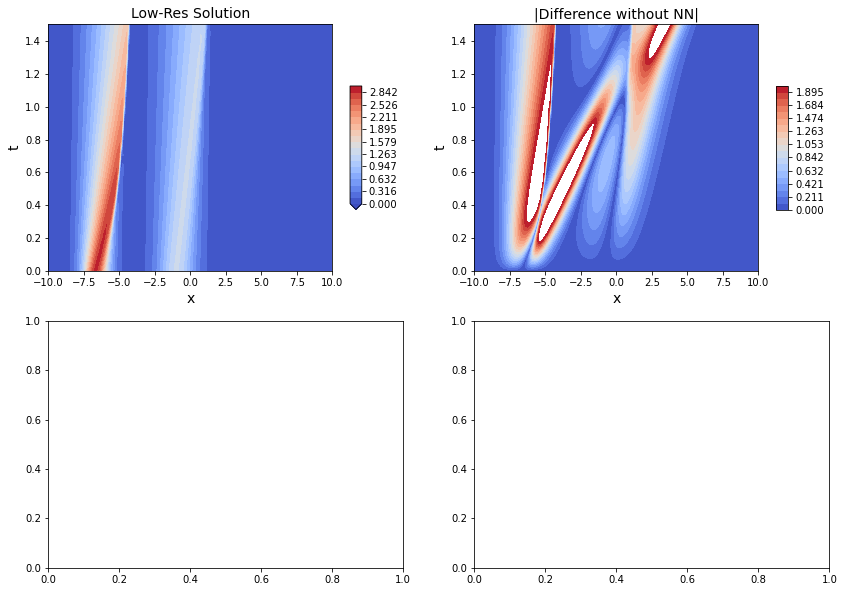

In [13]:
if args.restart == 1: 
    func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
    pred_zy = ddeinttf(func, true_u0, tf.concat([t, val_t], axis=0), fargs=(args.tau,), alg_name = args.ode_alg_name, nsteps = args.nsteps)
    
    plot_obj.plot(pred_zy[:, :, :args.args_eval_lf.state_dim], epoch = 0)

    loss_history.read()
    
    initial_learning_rate = 0.0004
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=args.niters, decay_rate=0.96, staircase=True)
    
else:
    plot_obj.plot(epoch = -1)

### Training starts here

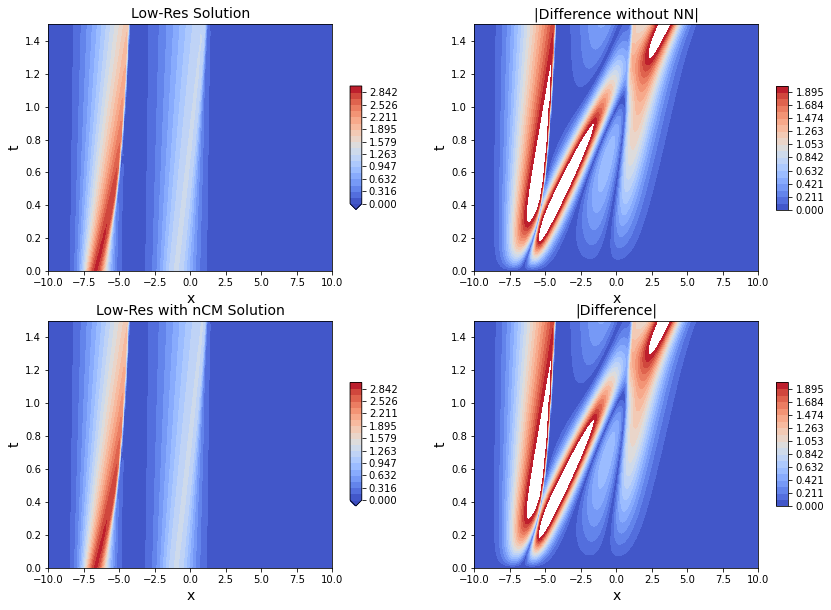

Epoch 0000 | Train Loss 0.622632 | Val Loss 0.696995 | Time Elapsed 0.0000 mins
Iterations:   0%|          | 0/4 [00:00<?, ?it/s]

/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1013: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Iterations: 100%|██████████| 4/4 [20:22<00:00, 305.51s/it]


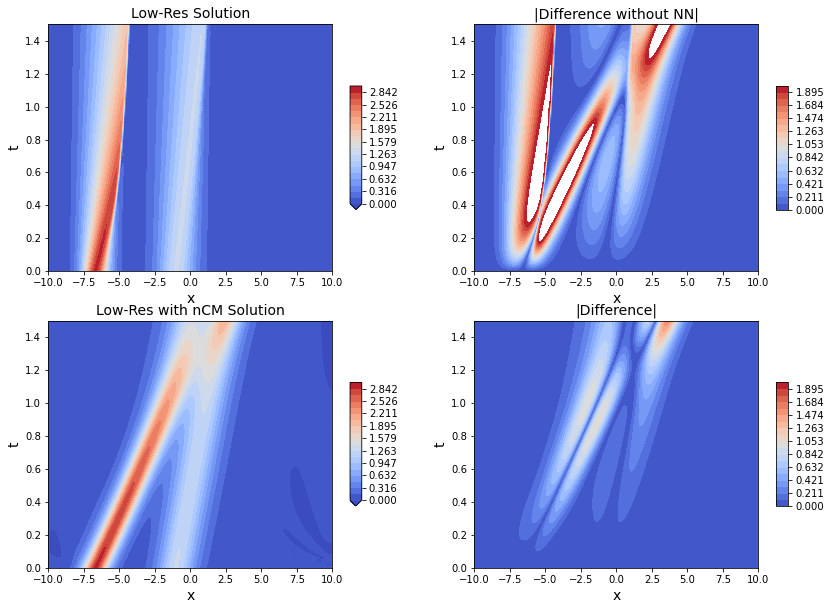

Epoch 0025 | Train Loss 0.284387 | Val Loss 0.422678 | LR 0.0350 | Time Elapsed 10.1860 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.07665491],
       [-0.97420335],
       [-3.9234626 ],
       [-0.419826  ]], dtype=float32)>
Iterations: 100%|██████████| 4/4 [20:35<00:00, 308.78s/it]


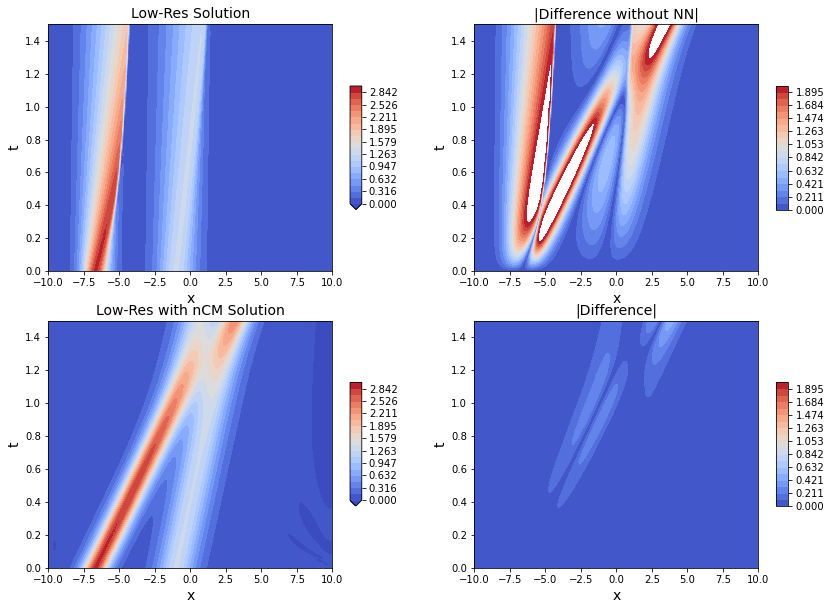

Epoch 0050 | Train Loss 0.137516 | Val Loss 0.215046 | LR 0.0164 | Time Elapsed 15.5478 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.01861406],
       [-1.0058883 ],
       [-4.793342  ],
       [-0.06463619]], dtype=float32)>
Iterations: 100%|██████████| 4/4 [19:49<00:00, 297.39s/it]


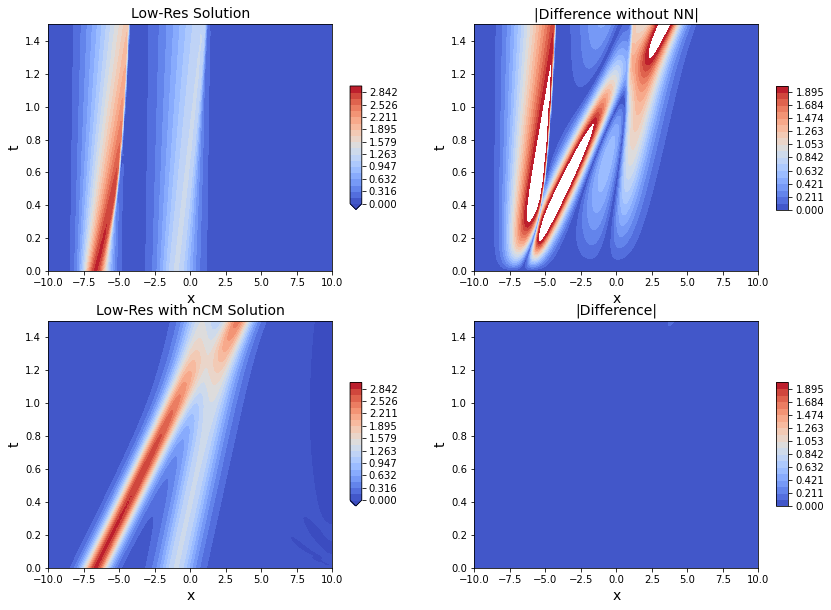

Epoch 0075 | Train Loss 0.060950 | Val Loss 0.101580 | LR 0.0076 | Time Elapsed 18.4900 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.00614628],
       [-1.0075684 ],
       [-4.962908  ],
       [ 0.        ]], dtype=float32)>
Iterations: 100%|██████████| 4/4 [19:10<00:00, 287.74s/it]


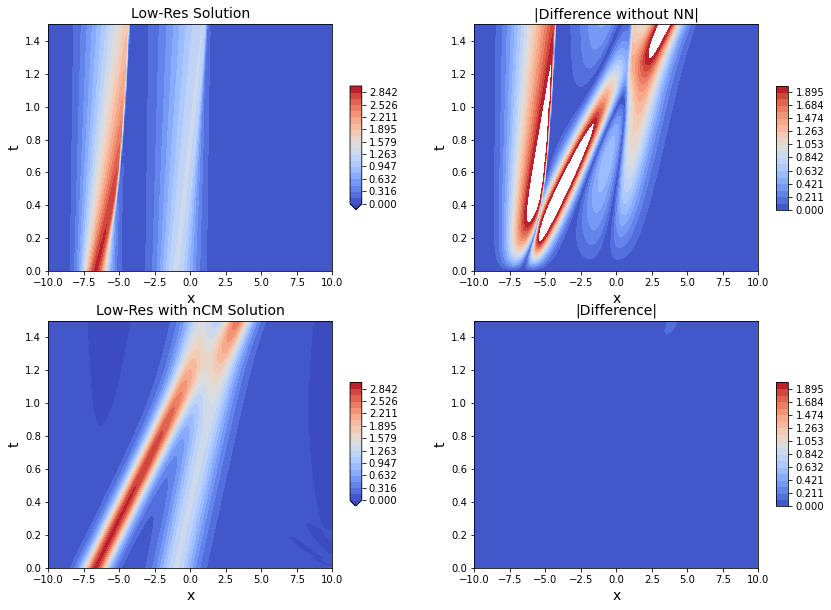

Epoch 0100 | Train Loss 0.081318 | Val Loss 0.099691 | LR 0.0036 | Time Elapsed 19.4050 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.       ],
       [-1.0096327],
       [-4.9676337],
       [ 0.       ]], dtype=float32)>
Iterations: 100%|██████████| 4/4 [16:38<00:00, 249.65s/it]


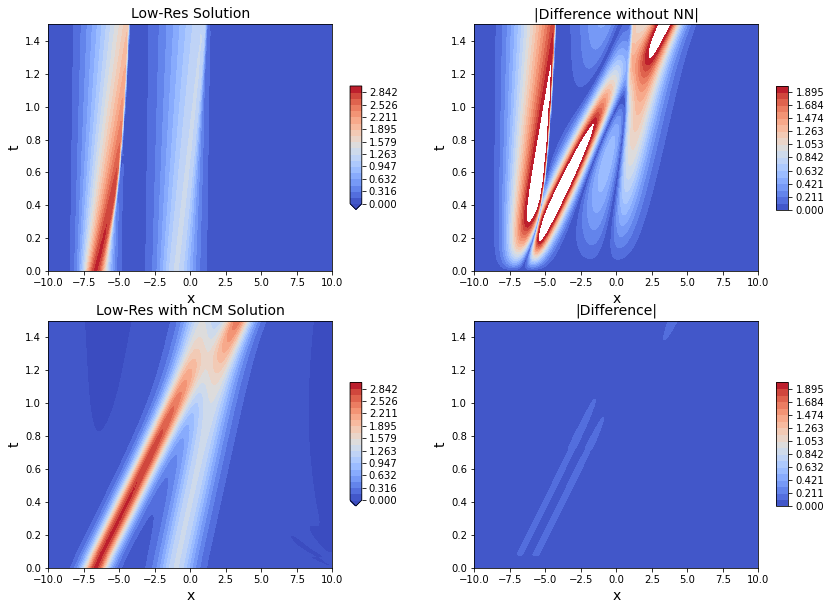

Epoch 0125 | Train Loss 0.120896 | Val Loss 0.116672 | LR 0.0017 | Time Elapsed 18.4981 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.       ],
       [-1.0107086],
       [-4.968693 ],
       [ 0.       ]], dtype=float32)>
Iterations: 100%|██████████| 4/4 [15:58<00:00, 239.74s/it]


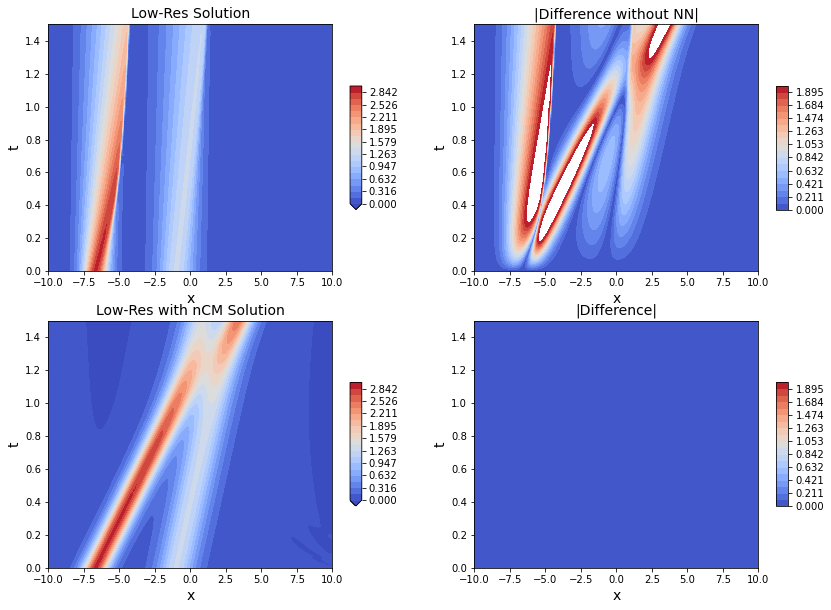

Epoch 0150 | Train Loss 0.052667 | Val Loss 0.070622 | LR 0.0008 | Time Elapsed 17.7912 mins
<tf.Variable 'dense/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.       ],
       [-1.010274 ],
       [-4.9688053],
       [ 0.       ]], dtype=float32)>


In [14]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr_schedule)

nODE_train_obj = ncm.train_nODE(func = func, rom_ens = burg_obj_ens, loss_obj = loss_obj,
                            optimizer = optimizer, args = args, plot_obj = plot_obj, time_meter = time_meter, checkpoint_dir = save_dir_obj.checkpoint_prefix,
                            validation_obj = val_obj, loss_history_obj = loss_history)

nODE_train_obj.train(true_z_ens = true_u_low_res_ens, true_z0_ens = true_u0_ens, 
                         t = t, eval_true_z = true_u_low_res, eval_true_z0 = true_u0, 
                         eval_val_true_z = val_true_u_low_res, eval_rom = eval_burg_obj, 
                         norm_eval = norm_eval, norm_train_ens = norm_train_ens)

Same as C11fc but with batch_size = 16, epochs = 150